## Random fields

In what follows, we step forward to the generation of a (input) random field $g\in L^P(\Omega,\Sigma, \mathbb{P}; \mathcal{X})$ with realisation in a Banach space $\mathcal{X}=\mathcal{X}(D)$ defined on some Lipschitz domain $D\subset\mathbb{R}^2$ for some $1<P< \infty$. For example we have $\mathcal{X} = L^\infty(D)$ for the diffusion field $g=a$ or $\mathcal{X} = H^{-1}(D)$ resp. $\mathcal{X} = L^2(D)$ for the case of right hand side $g=f$.

We will discuss two examples of random fields:

#### Implicit random field 
As an example we present a simple random cookie field, that models composite material.

#### Explicit parametric representation
Here we state representation by means of Karhunen–Loève expansion (KLE):
\begin{align}
\kappa(x,\omega) = \kappa(x, \xi(\omega)) = \kappa_0(x) + \sum\limits_{m=1}^\infty \sqrt{\lambda_m}\kappa_m(x)\xi_m(\omega)
\end{align}


##### remark
KLE based representation and its truncated version are one of the basis motivation for stochastic Galerkin methods based on generalized polynomial chaos expansions (gPCE), which extends Wiener's polynomial chaos expansion (w.r.t. to underlying Gaussian random variables).

### A table full of cookies

In the following we generate random fields by means of rejecting. This applies e.g. for coefficients describing random composite material. Here we model a matrix composite material with variable but fixed number of non-overlapping circular inclusions with random radii and positions also known as a random cookie material.





At first we load necessary packages.

In [1]:
from dolfin import *
from random import uniform
import mshr
import numpy as np

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.5

%matplotlib inline 

First we generate random radii and positions uniquely describing the circular inclusions.

In [2]:
def generate_non_overlapping_data(no_holes, size_D = [(0.,0.),(1.,1.)]):
    """"
    Generate radii and midpoint data for [no_holes] number of circular subdomains
    that do not overlap within a given distance dist_tol = 0.001.

    The midpoint lies within the region of interest specified by size_D.
    
    @param no_holes: number of circular subdomains
    @param size_D  : speficies the rectangular domain D

    @returns radii and midpoint data as lists
    """
    # compute noHoles configurations of voids not intersecting
    # presetted range of radii of the circular subdomains
    min_rad, max_rad = 0.15, 0.02

    # data for subdomain circles that not overlap...
    radii, m_x, m_y = [], [], []
    # by minimal distance of
    dist_tol = 0.005

    success = 0
    while success < no_holes:
        # generate a sample candidate
        rad_new = uniform(min_rad, max_rad)
        cx_new  = uniform(size_D[0][0], size_D[1][0])
        cy_new  = uniform(size_D[0][1], size_D[1][1])

        add = True
        # check if sample intersects with previous circular data
        for rad, cx, cy in zip(radii, m_x, m_y):
            distM = np.sqrt((cx_new - cx) ** 2 + (cy_new - cy) ** 2)
            if rad_new + rad + dist_tol > distM:
                add = False
                break

        if add:
            radii.append(rad_new)
            m_x.append(cx_new)
            m_y.append(cy_new)
            success += 1

    return radii, m_x, m_y

Next the above code is used to generate a realisation of the underlying random cookie field.

In [3]:
def composite_material(no, N):
    """
    Returns a realisation of a diffusion coefficient that is piecewise constant with
    circular inclusions, may represent composite material.
    @param no: number of holes
    @param N : discretisation
    :return: Fenics function and underlying mesh
    """

    coeff1 = 1.
    coeff2 = 10.


    # define 2D geometry
    size_D = [(0., 0.), (1., 1.)]
    domain = mshr.Rectangle(Point(size_D[0][0], size_D[0][1]), Point(size_D[1][0], size_D[1][1]))
    
    # get realisation of cookie data
    radii, m_x, m_y  = generate_non_overlapping_data(no)

    # set subdomains for an adapted mesh
    for k, data in enumerate(zip(radii, m_x, m_y)):
        r, x, y = data
        circ = mshr.Circle(Point(x, y), r)
        domain.set_subdomain(k+1, circ)

    # generate mesh
    mesh = mshr.generate_mesh(domain, N)

    # a subdomain class representing a cookie used for definition of the FE function field
    class circle(SubDomain):
        def __init__(self, r, mx, my):
            self._r = r
            self._mx = mx
            self._my = my
        def inside(self, x, on_boundary):
            return pow(x[0] - self._mx, 2) + pow(x[1] - self._my, 2) - pow(self._r, 2) <= dolfin.DOLFIN_EPS
    #collection of cookies
    circles = [ circle(r,mx,my) for r,mx,my in zip(radii, m_x, m_y)]

    # creation of discrete space of piecewise constant functions w.r.t. the mesh
    DG0 = FunctionSpace(mesh, "DG", 0)
    # create the output field
    field = Function(DG0)
    # data array associated for field
    data  = np.array([coeff2]*DG0.dim())
    
    # relation between d.o.fs and topological entities (cell midpoints)...
    dofs = DG0.dofmap().dofs()
    dofs_x = DG0.tabulate_dof_coordinates().reshape((-1, mesh.geometry().dim()))
    dofVertexMap = zip(dofs, dofs_x)

    # ... used to set the FE function field
    for dof, x in dofVertexMap:
        for circle in circles:
            if circle.inside(x, False):
                data[dof] = coeff1
                break
    field.vector()[:] = data
    
    return field, mesh

Now we generate a mesh and a cookie field for $15$ cookies.

In [4]:
field, mesh = composite_material(15, 40)

We plot the underlying mesh to observe the grain circles.

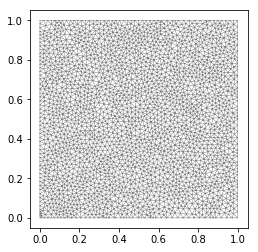

In [5]:
plot(mesh)

Now plot the field (based on matplotlib new mesh data).
The field takes the value $1.0$ inside the circle and $10.0$ in the outer media. 

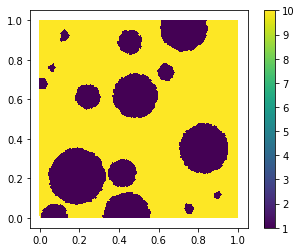

In [6]:
plt_field = plot(field)    # fenics.plot returns a matplotlib object
mpl.pyplot.colorbar(plt_field)

# Exercise I 
Numerically solve the diffusion problem with homogeneous Dirichlet b.c. using the cookie field as diffusion coefficient and plot the discrete solution.

Calling FFC just-in-time (JIT) compiler, this may take some time.


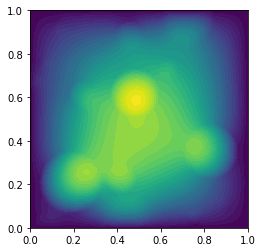

In [7]:
fe_type = "Lagrange"
fe_degree = 1
V = FunctionSpace(mesh, fe_type, fe_degree)

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, 'on_boundary')

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
kappa = field
f = Constant(1) # Expression("1", degree=3)
a = inner(kappa*grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

plot(u)

End of part II. Next: *random fields Part 2*

<div style="text-align: right; color: #a5a9af"> &copy; Robert Gruhlke, Manuel Marschall, Phillip Trunschke, 2018-2019</div>